In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import the data covert that into a convenient data
PATH= '/home/ac-optimus/data_science/recommendation_sys/ratings_small.csv'
df = pd.read_csv(PATH, sep= ",")
# df = pd.read_csv(PATH, sep= ",")
df.shape

(100004, 4)

In [3]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [4]:
# this gave me a good plot
from sklearn.utils import shuffle
df = shuffle(df)

In [5]:
df.head()

,userId,movieId,rating
61320,450,4873,5.0
55900,405,648,2.0
86443,578,1196,0.5
55923,405,1087,3.5
91849,608,696,1.0


In [6]:
num_rows = df.shape[0]
train, test = df.copy(deep = True), df[int(num_rows*0.8):].copy(deep = True)
train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0
train = shuffle(train)

<ipython-input-6-75ff325d5135>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0


In [7]:
user_movie_rating =train.groupby(['userId','movieId'])['rating'].max().unstack().fillna(0)
user_movie_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
central_mean = user_movie_rating.sub(user_movie_rating.mean(axis=1), axis=0)
central_mean.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,...,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750,-0.003750
2,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,3.974630,...,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370,-0.025370
3,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,...,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159,-0.016159
4,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,3.921685,...,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315,-0.078315
5,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,...,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903,-0.035903


In [9]:
user_movie_rating.shape
print ("We have {} users in our user-movie matrix.".format(user_movie_rating.shape[0]))
print ("We have {} movies in our user-movie matrix.".format(user_movie_rating.shape[1]))


We have 671 users in our user-movie matrix.
We have 9066 movies in our user-movie matrix.


In [10]:
correlation_matrix = user_movie_rating.corr()
correlation_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.139555,0.128125,0.058892,0.107724,0.139330,0.129784,0.007196,0.022741,0.041319,...,NaN,0.017985,-0.024211,0.081279,NaN,0.081279,-0.024211,NaN,-0.024211,NaN
2,0.139555,1.000000,0.111003,0.055651,0.137014,0.095027,-0.008758,0.176114,0.052506,0.296724,...,NaN,0.051776,-0.014462,0.084895,NaN,-0.014462,-0.014462,NaN,-0.014462,NaN
3,0.128125,0.111003,1.000000,0.111916,0.228635,0.128911,0.284848,0.137551,0.301862,0.043167,...,NaN,-0.010577,-0.010577,0.117681,NaN,-0.010577,-0.010577,NaN,-0.010577,NaN
4,0.058892,0.055651,0.111916,1.000000,0.110005,0.051695,0.076066,0.403128,0.180753,0.086685,...,NaN,-0.004452,-0.004452,-0.004452,NaN,-0.004452,-0.004452,NaN,-0.004452,NaN
5,0.107724,0.137014,0.228635,0.110005,1.000000,0.113190,0.252538,0.124522,0.219156,0.173738,...,NaN,0.199375,-0.009548,0.129734,NaN,-0.009548,-0.009548,NaN,-0.009548,NaN


In [11]:
# person similarity based

# when we want to find a recommendaiton for a user.
# we compute the correlation(cetered cosine or person correlation, making a saperate column would be a good idea)
# with all the users in the utility matrix
# return the top movies that user had not watched yet and recommend that movie
# main aim is to fill the values that is it.
# central_mean.iloc[0].corr(central_mean.iloc[1])
# user_movie_rating= central_mean

In [12]:
def error(y_hat, y):
    # MSE
    y_hat = np.array(y_hat)
    y = np.array(y)
    MSE_ = (y_hat- y)**2
    MSE = MSE_.sum()
    return MSE

### Similarity based

In [13]:
def PredictMovieRating(user_i, movie_i, corr_mat, user_movie_rating, k):
    # for user x
    # rxi = sum over knn (sxy*ryi)/sum over all the knn similarities
    all_neighbours = corr_mat.loc[movie_i]
    all_neighbours = all_neighbours.drop(movie_i)
    topk_neighbours = all_neighbours.sort_values(ascending=False)[:k]  # knn
    # knn user ids
    knn = topk_neighbours.index.tolist()
#     return knn
    sum_sim = sum([corr_mat[movie_i][movie_j] for movie_j in knn])
    weighted_sum_sim = sum([corr_mat[movie_i][movie_j]
                            *user_movie_rating[movie_j][user_i] 
                           for movie_j in knn])
    predicted_rating = weighted_sum_sim/sum_sim
    return predicted_rating

In [14]:
# Similarity based
# we have to keep  a correlation matrix. we can say that we update this on regular intervals
# use the prediction formulae given in the video
# here we need k nearest neighbours based on whome we can make a prediction
# how do we decide k?
# def PredictMovieRating(user_i, movie_i, corr_mat, user_movie_rating):
#     # for user x
#     # rxi = sum over knn (sxy*ryi)/sum over all the knn similarities
#     all_neighbours = corr_mat.iloc[user_i]
#     all_neighbours.drop(user_i)
#     topk_neighbours = all_neighbours.sort()[:k]  # knn
#     # knn user ids
#     knn = topk_neighbours.index.tolist()
    
#     sum_sim = sum([corr_mat[user_i][user_j] for user_j in knn])
#     weighted_sum_sim = sum([corr_mat[user_i][user_j]*user_movie_rating[user_j][movie_i] 
#                            for user_j in knn])
#     predicted_rating = weighted_sum_sim/sum_sim
#     return predicted_rating
    
def Prediction(user_i, intial_mat, user_movie_rating, corr_mat):
    # return a list of movieIds as prediction
    # we wont populate user_movie_rating here, let the user do that after he has watched the movie
    predicted_ratings = []  # a heap
    movieIds = intial_mat.columns()
    for movieId in movieIds:
        if intial_mat[user_i][movieId] == 'Null': # check if null value
            # time to predict rating for this movie
            rating = PredictMovieRating(user_i, movieId, corr_mat, user_movie_rating)
            predicted_ratings.append((rating, movieId))
    predicted_ratings.sort(key= lambda x:x[0])
    movie_predictions = [x[1] for x in predicted_ratings]
    return movie_predictions


In [15]:
# to compute error
# create a new matrix that has ratings based on similarities 
# compare with the y and yhat and get the error
# we can use the same split of test and train as in assignment.

# obtain the optimal k

In [54]:
%%time
# looking for optimal k
y= test['rating']
errors = {}
for k in range(1, 20):
    y_hat = []
    for i in test.index:
        user_i, movie_j = map(int,[test.loc[i]['userId'], 
                                   test.loc[i]['movieId']])
        # make the prediction here
        predicted_rating = PredictMovieRating(user_i, 
                                              movie_j, 
                                              correlation_matrix, 
                                              user_movie_rating, k)
        y_hat.append(predicted_rating)
    error_i = error(np.nan_to_num(np.array(y_hat)), y)        
    errors[k]=error_i


CPU times: user 20min 35s, sys: 2.79 s, total: 20min 38s
Wall time: 20min 59s


Text(0.5, 1.0, 'optimal neighbour search')

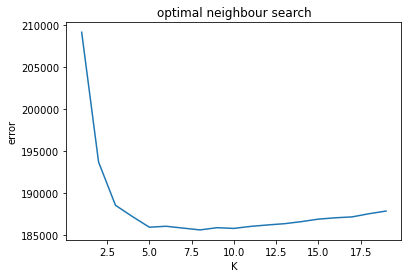

In [55]:
plt.plot(errors.keys(), errors.values())
plt.xlabel('K')
plt.ylabel('error')
plt.title('optimal neighbour search')

# Evaluation

### optimial k =8

In [16]:
%%time
# looking for optimal k
y= test['rating']
errors = {}
y_hat = []
for i in test.index:
    user_i, movie_j = map(int,[test.loc[i]['userId'], 
                               test.loc[i]['movieId']])
    # make the prediction here
    predicted_rating = PredictMovieRating(user_i, 
                                          movie_j, 
                                          correlation_matrix, 
                                          user_movie_rating, 8)
    y_hat.append(predicted_rating)
error_i = error(np.nan_to_num(np.array(y_hat)), y)        


CPU times: user 1min 1s, sys: 68.1 ms, total: 1min 1s
Wall time: 1min 1s


In [17]:
y= test['rating'].tolist()
# compute error
error(np.nan_to_num(np.array(y_hat)), y)

193921.69619113905

In [18]:
test['prediction'] = y_hat
test.head()

,userId,movieId,rating,prediction
38882,285,370,1.0,0.706353
61099,445,4874,4.0,0.000000
72888,509,3081,3.5,0.487943
65623,467,2154,4.0,0.000000
94577,624,46062,3.5,0.283187


In [19]:
from collections import Counter
user_freq_dict = Counter(test['userId'].tolist())
max_voting = max(user_freq_dict.values())
for i in user_freq_dict:
    if user_freq_dict[i] == max_voting:
        print(i)
user_freq_dict[547]

547


494

In [94]:
one_user= test.loc[(test['userId'] == 17)].sort_values('rating', 
                      inplace=False, 
                      ascending=False)
one_user.head()

,userId,movieId,rating,prediction
2698,17,111,5.0,2.598993
2842,17,2579,5.0,0.000000
3006,17,7587,5.0,0.000000
2773,17,1246,5.0,0.000000
2924,17,5105,5.0,0.000000


### Recall and Precision

In [95]:
relevance_threshold = 2
recommended_movies = set(one_user.loc[(one_user['prediction'] >= relevance_threshold)]['movieId'].tolist())
relavent_movies = set(one_user.loc[(one_user['rating'] >= relevance_threshold)]['movieId'].tolist())
len(relavent_movies), len(recommended_movies)

(82, 7)

In [96]:
recommended_movies_intersection_relavant_movies = [i for i in recommended_movies if i in relavent_movies]
recommended_movies_intersection_relavant_movies;

In [97]:
recall = len(recommended_movies_intersection_relavant_movies)/len(relavent_movies)
precision = len(recommended_movies_intersection_relavant_movies)/len(recommended_movies)

In [98]:
len(recommended_movies), len(recommended_movies_intersection_relavant_movies), len(relavent_movies)

(7, 7, 82)

In [99]:
precision, recall

(1.0, 0.08536585365853659)

In [100]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.15730337078651685

### Recall@k and Precision@k

In [101]:
k=8
top_k_predictions_df = one_user.sort_values('prediction', ascending=False)[:k]
top_k_predictions_df.head()

,userId,movieId,rating,prediction
2862,17,2959,5.0,3.333757
2916,17,4993,4.5,2.953773
2710,17,296,5.0,2.899922
2698,17,111,5.0,2.598993
2933,17,5445,4.5,2.573050


In [102]:
relevance_threshold=2
top_k_movies_recommended = set(top_k_predictions_df.loc[(top_k_predictions_df['prediction'] >= relevance_threshold)]['movieId'].tolist())
top_k_movies_relevant = set(top_k_predictions_df.loc[(top_k_predictions_df['rating'] >= relevance_threshold)]['movieId'].tolist())
# top_k_predictions_df['rating']

In [103]:
recommended_movies_intersection_relavant_movies = [i for i in top_k_movies_recommended
                                                   if i in top_k_movies_relevant]
recommended_movies_intersection_relavant_movies

[4993, 5445, 296, 2762, 111, 2959, 1104]

In [104]:
len(top_k_movies_recommended), len(recommended_movies_intersection_relavant_movies), len(top_k_movies_relevant)

(7, 7, 8)

In [105]:
recall = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_relevant)
precision = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_recommended)

In [106]:
precision, recall

(1.0, 0.875)

In [107]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.9333333333333333